In [106]:
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt
import plotly.express as px
from collections import defaultdict
import json
from collections import Counter
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from IPython.core.display import display, HTML
#%matplotlib inline  


In [107]:
## Access to all the data 
display(HTML("""<a href="https://github.com/tingtingbun/interactiveds/tree/master/interactive">datafile</a>"""))

## PART I: Data Loading 
### Data Sources: There are a total of three data files from seperate sources 
#### a. file one: a file with seperate excel sheet containing baby names from social security application for all states (including the district of columbia from 1910 - 2018) 
#### b. file two: a single excel sheet containing the median income for all states (including the district of columbia) from 1984 - 2018 
#### c. file three: a json file that records the corresponding state codes for all states 
### Data Description 
#### a. file one: five fields ['State','Names','Year of  birth','Number of Occurrences']
#### b. file two: two fields ['Year','Median Income']
#### c. file three: sample format {"state code 1":"state 1"}
### Data Integration 
#### a. Based on file three, we replace the state name with the state code to prepare for the table join on file one and file two 
#### b. Join file one and file two on two fields ['Year','State']
#### c. Since we do not have data points on year prior to 1984 on median income, we would restrict our final dataset to 1984 - 2018 
#### d. Other remarks: there is no missing value in the dataset

In [108]:
### dataset loading 
def data_loading (name_file, state_file, us_abbre_file):
    df = pd.concat([pd.read_csv(name_file+'/' + i, sep=",",header=None) for i in os.listdir('namesbystate') if not i.startswith('.')]\
                  ,ignore_index=True)
    df.columns = ['State','Sex','Year_of_birth','Name','Num_of_occurrences']
    print('There are {} states in the dataset and they are {}'.format(len(df.State.unique().tolist()),df.State.unique().tolist()))
    ### To check all 50 + D.C. are loaded correctly
    
    ### loading income dataset
    df_income = pd.read_excel(state_file, header=[0])
    df_income = pd.melt(df_income, id_vars='State', value_vars=df_income.columns.tolist()[1:])
    df_income.rename(columns={"variable": "year", "value":"median_income"}, inplace = True)
    
    ### loading state abbrev json
    with open (us_abbre_file) as file:
        us_code = {y:x for x,y in json.load(file).items()}
        
    ### replacing abbreviation 
    for index, content in df_income.iterrows():
        if content['State'] == 'United States':
            pass
        else:
            df_income.loc[index,'State'] = us_code[content['State']]
    
    return pd.merge(df_income, df, left_on = ['State','year'], right_on =['State','Year_of_birth'])

In [109]:
a = data_loading('namesbystate','h08-2.xls','state_code.json')
a = a[a.year > 2007]

There are 51 states in the dataset and they are ['IN', 'IL', 'KS', 'SC', 'HI', 'GA', 'SD', 'CO', 'NH', 'MS', 'MD', 'UT', 'LA', 'ME', 'WI', 'NJ', 'AR', 'NY', 'MT', 'OK', 'MA', 'NM', 'WY', 'OH', 'OR', 'NV', 'TX', 'TN', 'AZ', 'MN', 'WA', 'WV', 'NC', 'MO', 'AL', 'VA', 'CA', 'CT', 'AK', 'ND', 'VT', 'MI', 'NE', 'KY', 'ID', 'DC', 'IA', 'FL', 'PA', 'RI', 'DE']


In [4]:
print('The head 5 rows of the data \n\n' + a.head().to_string() + '\n\n')

print('Basic description of different fields in the integrated dataset \n\n' + a.describe().to_string())

The head 5 rows of the data 

  State  year  median_income Sex  Year_of_birth    Name  Num_of_occurrences
0    AL  2018          49936   F           2018     Ava                 293
1    AL  2018          49936   F           2018  Olivia                 259
2    AL  2018          49936   F           2018  Harper                 204
3    AL  2018          49936   F           2018    Emma                 202
4    AL  2018          49936   F           2018  Amelia                 183


Basic description of different fields in the integrated dataset 

       median_income  Year_of_birth  Num_of_occurrences
count   2.879400e+06   2.879400e+06        2.879400e+06
mean    4.367943e+04   2.002096e+03        4.061643e+01
std     1.284236e+04   1.017420e+01        1.278418e+02
min     1.543000e+04   1.983000e+03        5.000000e+00
25%     3.366400e+04   1.994000e+03        7.000000e+00
50%     4.346400e+04   2.003000e+03        1.100000e+01
75%     5.201900e+04   2.011000e+03        2.700000e+0

## PART II: Data Insights (Tableau)


## PART III: Gender Neutrality

### a) 

In [111]:
def return_data_desired (df): 
    ### visualization of name lists with equal distribution between genders
    ### and understanding the trade off between percentent difference and total number of occurrences
    
    gender_df = df.groupby(['State','year','Name','Sex']).agg({'Num_of_occurrences': 'sum'}).unstack().fillna(0)
    bi_gender = gender_df.Num_of_occurrences[(gender_df.Num_of_occurrences.F > 0) & (gender_df.Num_of_occurrences.M > 0)]
    
    ### Deriving two filds 
    bi_gender['diff'] = abs(bi_gender.F - bi_gender.M)
    bi_gender['percent_dff'] = abs(bi_gender.F - bi_gender.M )/(bi_gender.M+bi_gender.F)
    bi_gender['Total_num'] = bi_gender.M+bi_gender.F 
    absolute_equal = bi_gender[(bi_gender['percent_dff'] == 0)] ### -> this gives a dataframe with names that are equally 
    absolute_equal.reset_index(inplace = True)     ###    shared between men and women 
    return absolute_equal

In [112]:
data = return_data_desired(a)
data1 = data.groupby(['year']).agg({"Total_num":"sum"})
total_pop = a.groupby(['year']).agg({'Num_of_occurrences': 'sum'})
overall = total_pop.join(data1)
overall.rename(columns = {"Total_num":"Neutral Babies","Num_of_occurrences":"Total Babies"},inplace = True)
overall['percent'] = overall["Neutral Babies"]/overall["Total Babies"]
overall

,Total Babies,Neutral Babies,percent
year,,,
2008,3343650,1300.0,0.000389
2009,3236049,1658.0,0.000512
2010,3121194,1404.0,0.000450
2011,3084961,2024.0,0.000656
2012,3081715,1622.0,0.000526
2013,3077781,1710.0,0.000556
2014,3139432,1570.0,0.000500
2015,3131544,2300.0,0.000734
2016,3095501,2274.0,0.000735


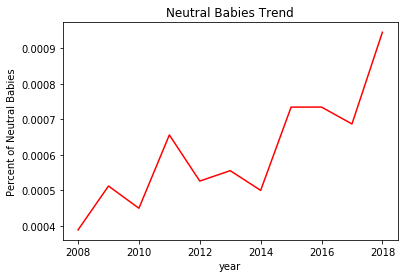

<Figure size 432x288 with 0 Axes>

In [113]:
plt.plot(overall.index, overall['percent'], color='r')
plt.xlabel('year')
plt.ylabel('Percent of Neutral Babies')
plt.title('Neutral Babies Trend')
plt.show()
plt.savefig('baby_neutral.png')

In [116]:
### Generating State-specific Dataset for Tableau 

data_state = data.groupby(['State','year']).agg({"Total_num":"sum"})
total_pop_state = a.groupby(['State','year']).agg({'Num_of_occurrences': 'sum'})
overall_state = total_pop_state.join(data_state)
overall_state.rename(columns = {"Total_num":"Neutral Babies","Num_of_occurrences":"Total Babies"},inplace = True)
overall_state['percent'] = overall_state["Neutral Babies"]/overall_state["Total Babies"]

In [8]:
def gender_neutral_visualize (df): 
    ### visualization of name lists with equal distribution between genders
    ### and understanding the trade off between percentent difference and total number of occurrences
    
    gender_df = df.groupby(['Name','Sex']).agg({'Num_of_occurrences': 'sum'}).unstack().fillna(0)
    bi_gender = gender_df.Num_of_occurrences[(gender_df.Num_of_occurrences.F > 0) & (gender_df.Num_of_occurrences.M > 0)]
    
    ### Deriving two filds 
    bi_gender['diff'] = abs(bi_gender.F - bi_gender.M)
    bi_gender['percent_dff'] = abs(bi_gender.F - bi_gender.M )/(bi_gender.M+bi_gender.F)
    bi_gender['Total_num'] = bi_gender.M+bi_gender.F 
    absolute_equal = bi_gender[(bi_gender['percent_dff'] == 0)] ### -> this gives a dataframe with names that are equally 
    absolute_equal.reset_index(inplace = True)                 ###    shared between men and women 
    
    ### Plotting for equally shared name and the total occurences of the name
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
    x = absolute_equal.Name.tolist()
    y_pos = np.arange(len(x))
    y = absolute_equal['Total_num'].tolist()

    ax1.bar(y_pos, y, align='center', alpha=0.6)
    ax1.set_xticks(y_pos)
    ax1.set_xticklabels(x, rotation=90)
    ax1.set_ylabel('Num of Occurrences')
    ax1.set_title('Absolute Gender Neutral Names')
    
    max_state = absolute_equal[absolute_equal.Total_num==absolute_equal.Total_num.max()].Name.values[0]
    print(max_state)
    arrow_x = absolute_equal[absolute_equal.Total_num==absolute_equal.Total_num.max()].index.values[0] + 0.5
    arrow_y = absolute_equal.Total_num.max() -1
    ax1.annotate('max name is {} and the total count is  {}'.format(max_state,absolute_equal.Total_num.max()) \
             ,  xy=(arrow_x, arrow_y), xytext=(arrow_x-20, arrow_y), arrowprops=dict(facecolor="black", width=4,headwidth=10, shrink=0.2))
   
    
    
    ### Plotting for percent difference against total number of occurrences 
    ax2.scatter(x=bi_gender['percent_dff'],y=bi_gender['Total_num'])
    ax2.set_xlabel('Normalized Difference')
    ax2.set_ylabel('Num of occurrences')
    ax2.set_title('occurrences and Percent_diff Trade-off')
    

Rei


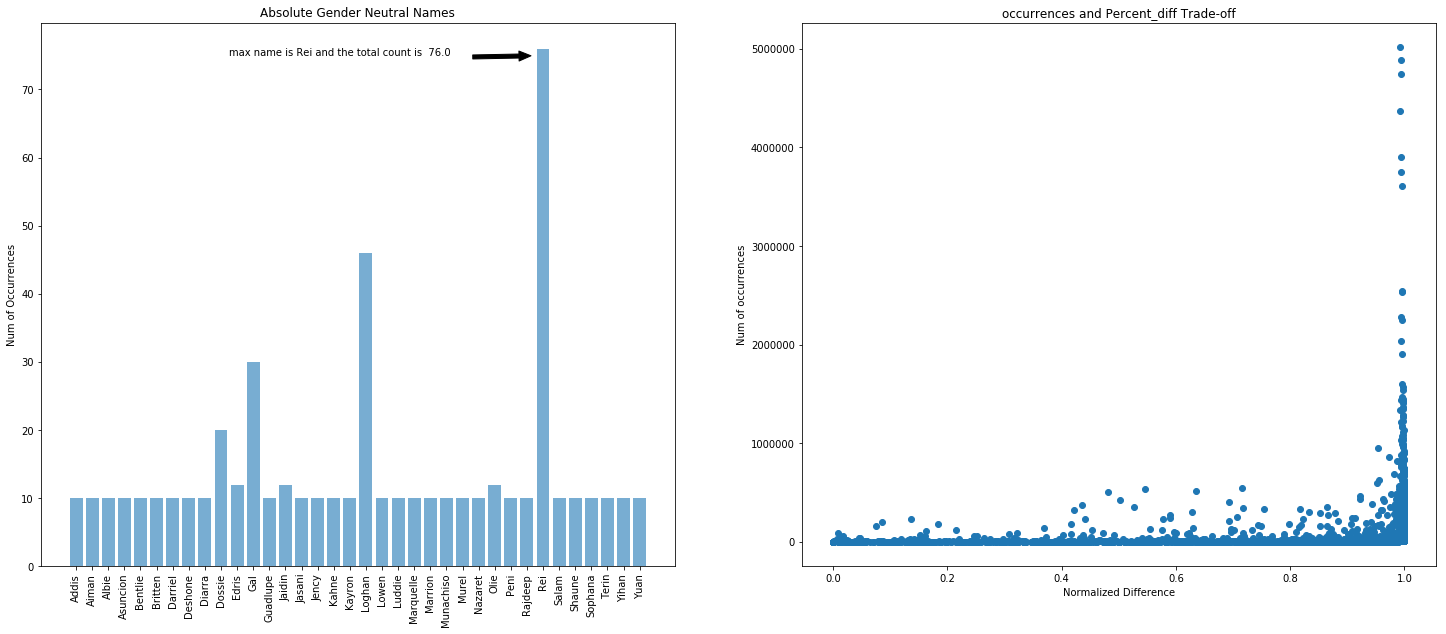

In [0]:
gender_neutral_visualize(a)  

### b) Nutrality Score Calculation 
#### * note that names with percent difference greater than 0.5 are excluded

In [85]:
def algorithm_calculation (df, location='All'):
    gender_df = df.groupby(['Name','Sex']).agg({'Num_of_occurrences': 'sum'}).unstack().fillna(0)
    bi_gender = gender_df.Num_of_occurrences[(gender_df.Num_of_occurrences.F > 0) & (gender_df.Num_of_occurrences.M > 0)]
    
   
    
    bi_gender['percent_dff'] = abs(bi_gender.F - bi_gender.M )/(bi_gender.M+bi_gender.F)
    bi_gender['Total_num'] = bi_gender.M+bi_gender.F  ### replicating the aggregated and derived dataframe
    bi_gender_ii = bi_gender[(bi_gender['percent_dff']<=0.5) & (bi_gender.index!= 'Unknown')].copy()
   
    bi_gender_ii['percent_diff_rank'] = bi_gender_ii['percent_dff'].rank(ascending=False) ### ranking the total percent_diff, the lower the higher rank score
    bi_gender_ii['Total_num_rank'] = bi_gender_ii['Total_num'].rank() ### ranking the total num, the higher the higher rank score 
    bi_gender_ii['score'] = bi_gender_ii['percent_diff_rank']+0.75*bi_gender_ii['Total_num_rank'] ### combined score calculate by the weighting coefficient
    bi_gender_ii.sort_values(by='score',ascending = False, inplace = True)
    
    return bi_gender_ii
    

In [86]:
gender_df = algorithm_calculation(a) 

In [88]:
gender_df.head(10) ### Tableau Data

Sex,F,M,percent_dff,Total_num,percent_diff_rank,Total_num_rank,score
Name,,,,,,,
Oakley,3239.0,3166.0,0.011397,6405.0,256.0,244.0,439.00
Briar,1578.0,1578.0,0.000000,3156.0,265.5,226.0,435.00
Dakota,13165.0,11408.0,0.071501,24573.0,235.0,263.0,432.25
Milan,3872.0,4226.0,0.043714,8098.0,242.0,248.0,428.00
Justice,6444.0,5818.0,0.051052,12262.0,238.0,253.0,427.75
Landry,2351.0,2247.0,0.022619,4598.0,250.0,236.0,427.00
Jael,1189.0,1162.0,0.011484,2351.0,255.0,218.0,418.50
Lennon,3361.0,2894.0,0.074660,6255.0,234.0,242.0,415.50
Skyler,8849.0,11143.0,0.114746,19992.0,218.0,261.0,413.75


## Part IV Longevity Prediction

In [91]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [129]:
### dataset getting ready 
min_df = a.groupby(['Name']).agg({"year":min})
min_df.rename(columns = {"year":"year_min"}, inplace = True)
max_df = a.groupby(['Name']).agg({"year":max,"State":pd.Series.nunique})
long_df = min_df.join(max_df)
long_df['duration']  = long_df['year']- long_df['year_min'] +1
regression_df = gender_df.join(long_df)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(regression_df[['F','M','State','score']], regression_df['duration'], test_size=0.2, random_state=0)

In [131]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df['absolute mean error']= abs(df['Actual']-df['Predicted'])
#df.sort_values('absolute mean error', ascending = False)

In [132]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.0275969693157117
Mean Squared Error: 6.209622510663691
Root Mean Squared Error: 2.491911417098066


In [133]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,5),
            'n_estimators': (10, 20, 30, 40),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

/Users/tingtinggu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [134]:
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [135]:
y_predict_rf_1 = rfr.predict(X_train)
df_rf_1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_predict_rf_1 })
y_predict_rf_2 = rfr.predict(X_test)
df_rf_2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_predict_rf_2 })
df_rf = df_rf_1.append(df_rf_2)
df_rf['absolute mean error'] = abs(df_rf["Predicted"]- df_rf["Actual"])

In [137]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_rf_2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_rf_2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_rf_2)))

Mean Absolute Error: 1.091657002947194
Mean Squared Error: 3.631039189754201
Root Mean Squared Error: 1.9055285853941424
